<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Fine-tuning" data-toc-modified-id="Fine-tuning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Fine-tuning</a></span></li></ul></div>

In [1]:
from tensorflow.keras.applications import VGG16,ResNet50
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL
import pathlib
import os
import numpy as np
%matplotlib inline

In [2]:
conv_base=ResNet50(weights='imagenet',include_top=False,input_shape=(250,250, 3))

In [3]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 125, 125, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 125, 125, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [4]:
!ls "../data/cats_and_dogs"

train
validation
vectorize.py


In [5]:
base_dir="../data/cats_and_dogs"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [6]:
datagen = ImageDataGenerator(rescale=1./255,rotation_range=20)
batch_size = 20

In [7]:
def extract_features(directory, sample_count):
    features=np.zeros(shape=(sample_count,8,8,2048))
    label=np.zeros(shape=(sample_count))
    datagenerator=datagen.flow_from_directory(directory,
                                       batch_size=batch_size,
                                       target_size=(250,250),
                                       class_mode='binary')
    i=0
    for inputs_batch,labels_batch in datagenerator:
        features_batch=conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size]=features_batch
        label[i*batch_size:(i+1)*batch_size]=labels_batch
        i+=1
        if i*batch_size >=sample_count:
            break
        return features,label
    

In [8]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
# reshaping the data to shape which will be accepted by the dense layers
train_features=np.reshape(train_features,(2000,8*8*2048))
validation_features=np.reshape(validation_features,(1000,8*8*2048))

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(256, activation='relu', input_dim=8 * 8 * 2048))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [11]:
history = model.fit(train_features, train_labels,epochs=6,batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/6
2000/2000 [==============================] - 61s 30ms/sample - loss: 0.7007 - acc: 0.9965 - val_loss: 0.7197 - val_acc: 0.9890
Epoch 2/6
2000/2000 [==============================] - 62s 31ms/sample - loss: 0.6877 - acc: 0.9970 - val_loss: 0.6838 - val_acc: 0.9910
Epoch 3/6
2000/2000 [==============================] - 62s 31ms/sample - loss: 0.6885 - acc: 0.9950 - val_loss: 0.6831 - val_acc: 0.9890
Epoch 4/6
2000/2000 [==============================] - 71s 35ms/sample - loss: 0.6827 - acc: 0.9955 - val_loss: 0.6912 - val_acc: 0.9890
Epoch 5/6
2000/2000 [==============================] - 75s 37ms/sample - loss: 0.6792 - acc: 0.9970 - val_loss: 0.6927 - val_acc: 0.9890
Epoch 6/6
2000/2000 [==============================] - 59s 29ms/sample - loss: 0.6736 - acc: 0.9960 - val_loss: 0.6830 - val_acc: 0.9890


In [12]:
epoch=np.arange(6)+1
epoch

array([1, 2, 3, 4, 5, 6])

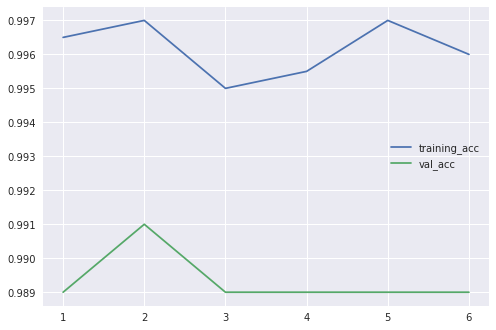

In [13]:
with plt.style.context('seaborn'):
    plt.plot(epoch,history.history['acc'],label='training_acc')
    plt.plot(epoch,history.history['val_acc'],label='val_acc')
    plt.legend()

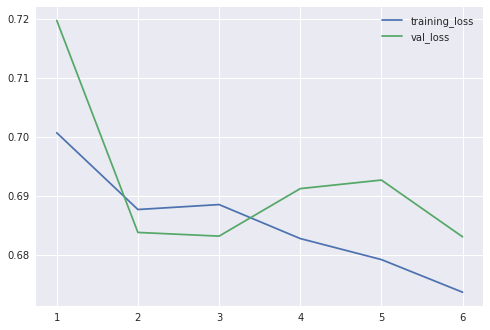

In [14]:
with plt.style.context('seaborn'):
    plt.plot(epoch,history.history['loss'],label='training_loss')
    plt.plot(epoch,history.history['val_loss'],label='val_loss')
    plt.legend()

# BUILDING A CLASSIFIER ON TOP OF THE PRETRAINED MODEL

In [15]:
net = tf.keras.models.Sequential()
net.add(conv_base)
net.add(tf.keras.layers.Flatten())
net.add(tf.keras.layers.Dense(256, activation='relu', input_dim=8 * 8 * 2048))
net.add(tf.keras.layers.Dropout(0.5))
net.add(tf.keras.layers.Dense(25, activation='relu'))
net.add(tf.keras.layers.Dropout(0.5))
net.add(tf.keras.layers.Dense(1, activation='sigmoid'))
net.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [16]:
net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33554688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                6425      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

Before you compile and train the model, it’s very important to freeze the convolutional base because we want to use it parameters without updating them. <b>Freezing</b> a layer or set of layers means preventing their weights from being updated during training.  In Keras, you freeze a network by setting its trainable attribute to False:

In [17]:
print('This is the number of trainable weights before freezing the conv base:',
     len(net.trainable_weights))

This is the number of trainable weights before freezing the conv base: 218


In [18]:
conv_base.trainable=False

In [19]:
print('This is the number of trainable weights after freezing the conv base:',
     len(net.trainable_weights))

This is the number of trainable weights after freezing the conv base: 6


With conv_base.trainable=False, only the weights from the two Dense layers that we have added will be trained.

## Fine-tuning
 Fine-tuning consists of unfreezing a few of  the top layers of a frozen model base (pretrained model) and jointly training both the newly added part of the model (on top of the pretrained model).
 

 Thus the steps for fine-tuning a network are as follow
    1. Add your custom network on top of an already-trained base network.
    2. Freeze the base network.
    3  Train the part you added.
    4  Unfreeze some layers in the base network.
    5  Jointly train both these layers and the part you added

In [21]:
conv_base.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 125, 125, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 125, 125, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

we will fine-tune the last two convolutional layers, which means all layers up to
conv5_block3_1_relu should be frozen and the layers conv5_block3_2_conv and conv5_block3_3_conv should be trainable


In [29]:
conv_base.trainable=True
layers_to_fine_tune=False
for layer in conv_base.layers:
    if layer.name=='conv5_block3_2_conv':
        layers_to_fine_tune=True
    if layers_to_fine_tune==True:
        layer.trainable=True
    if layer.name=='conv5_block3_3_conv':
        layers_to_fine_tune=True
    if layers_to_fine_tune==True:
        layer.trainable=True
    else:
        layer.trainable = False

In [30]:
print('This is the number of trainable weights after unfreezing conv5_block3_2_conv', 
      'and conv5_block3_3_conv of the conv base:',len(net.trainable_weights))

This is the number of trainable weights after unfreezing conv5_block3_2_conv and conv5_block3_3_conv of the conv base: 14


Now we will be fine-tuning (updating) the network during training